# ML@UVA Code.a.thon: Boston Housing Prices

Authors: Rohit Musti (rm3qg), Andrew Walsh (abw9yd)
Goal: create a model to predict prices of Boston Homes

#### Load Libraries and Set Constants

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import os as os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from scipy import stats
from scipy.stats import randint
from scipy.stats import geom, expon

import hashlib

from zlib import crc32

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Boston Housing Prices"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### Step 1: The Big Picture
Our goal is to use a machine learning model to predict median value of a given home.

#### Step 2: Get the data
This involved loading in the data from the CSV. At this point we spotted an issue.

##### Issue
We noticed that we were missing the headers in our data as kaggle had not included them in the original CSV. Luckily, Kaggle had posted information about the data and we were able to understand what headers corresponded to which column. We manually added the headers based on Kaggle's suggestions.

In [4]:

csv_path = os.path.join("./datasets/housing.csv") # path to the data
col_names = ["CRIME_RATE", "LOT_OVER_25", "PROP_INDUSTRY_ACRES", 
                           "CHARLES_RIVER", "NOX_CONCENTRATION", "RMS_PER_DWELLING",
                          "PRE_1940", "DISTANCE_TO_WORK", "HIGHWAY_ACCESS", "BIG_PROPERTY_TAX",
                          "ST_RATIO", "B_PROPORTION", "LOWER_STATUS", "MEDIAN_VALUE_1K"]

housing = pd.read_csv(csv_path, delimiter=r'\s+', names=col_names)

#### Step 3: Discover and Visualize the Data to Gain Insights
It is important to get a good understanding of the quirks of the data. The next few cells are dedicated to understanding the data more clearly.

In [5]:
print("This data has (rows, columns):", housing.shape) ### how many rows and columns in the data
housing.head() ### This shows us the columns names and the first 5 rows of data

This data has (rows, columns): (506, 14)


,CRIME_RATE,LOT_OVER_25,PROP_INDUSTRY_ACRES,CHARLES_RIVER,NOX_CONCENTRATION,RMS_PER_DWELLING,PRE_1940,DISTANCE_TO_WORK,HIGHWAY_ACCESS,BIG_PROPERTY_TAX,ST_RATIO,B_PROPORTION,LOWER_STATUS,MEDIAN_VALUE_1K
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIME_RATE             506 non-null float64
LOT_OVER_25            506 non-null float64
PROP_INDUSTRY_ACRES    506 non-null float64
CHARLES_RIVER          506 non-null int64
NOX_CONCENTRATION      506 non-null float64
RMS_PER_DWELLING       506 non-null float64
PRE_1940               506 non-null float64
DISTANCE_TO_WORK       506 non-null float64
HIGHWAY_ACCESS         506 non-null int64
BIG_PROPERTY_TAX       506 non-null float64
ST_RATIO               506 non-null float64
B_PROPORTION           506 non-null float64
LOWER_STATUS           506 non-null float64
MEDIAN_VALUE_1K        506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


In [7]:
housing.describe()
"""It is worth noting that there is a lot of decimal places in this data. Later on we may need
to shorten the information
"""

'It is worth noting that there is a lot of decimal places in this data. Later on we may need\nto shorten the information\n'

Saving figure attribute_histogram_plots


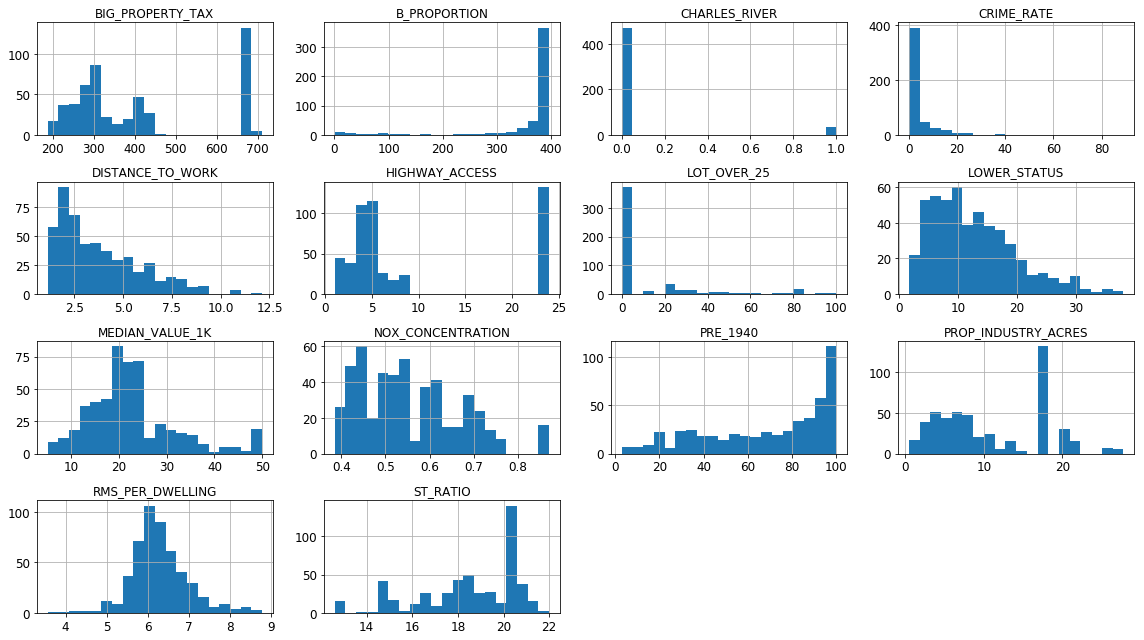

'\nIt is important to note that the Distance to Work and Lower Status columns \nhave similar distributions.\nRooms per dwelling and median value of similar shapes.\nIn general, the data has lots of tails so we will probably need to do some\nkind of normalizatin on it to help the machine learning functions work on it.\n'

In [8]:
%matplotlib inline
housing.hist(bins=20, figsize=(16, 9))
save_fig("attribute_histogram_plots")
plt.show()
"""
It is important to note that the Distance to Work and Lower Status columns 
have similar distributions.
Rooms per dwelling and median value of similar shapes.
In general, the data has lots of tails so we will probably need to do some
kind of normalizatin on it to help the machine learning functions work on it.
"""

##### Understanding what's correlated
Now that I have a good sense of what the data looks like, I need to determine what correlations exist. I can visually see that Pre_1940 and B_Proportion have similar shapes, most of the graphs have significant tails, and that there seems to be huge spikes in certain bins. However, I need a more granular understanding of what is correlated to what. After some googling, I found this [stack overflow post](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas) that offered some insights into how I might discover correlations. I used these methods to understand the data

In [47]:
print("Correlation Matrix")
print(housing.corr()['MEDIAN_VALUE_1K'])
print()

Correlation Matrix
CRIME_RATE            -0.388305
LOT_OVER_25            0.360445
PROP_INDUSTRY_ACRES   -0.483725
CHARLES_RIVER          0.175260
NOX_CONCENTRATION     -0.427321
RMS_PER_DWELLING       0.695360
PRE_1940              -0.376955
DISTANCE_TO_WORK       0.249929
HIGHWAY_ACCESS        -0.381626
BIG_PROPERTY_TAX      -0.468536
ST_RATIO              -0.507787
B_PROPORTION           0.333461
LOWER_STATUS          -0.737663
MEDIAN_VALUE_1K        1.000000
Name: MEDIAN_VALUE_1K, dtype: float64



##### Notable Correlations
I only selected the correlations for Median_Value_1k. It is clear that RMS_PER_DWELLING (the number of rooms per dwelling), ST_RATIO (student-teacher ratio), and LOWER_STATUS (percentage of home owners considered lower class) are all highly correlated with MEDIAN_VALUE_1k. 

##### Step 4: Prepare the data for Machine Learning algorithms
We will split the data into explanatory and dependent variables. We will also set aside some data for our testing at the end. 

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [48]:

X = housing[["CRIME_RATE", "LOT_OVER_25", "PROP_INDUSTRY_ACRES", "CHARLES_RIVER", 
            "NOX_CONCENTRATION", "RMS_PER_DWELLING", "PRE_1940", "DISTANCE_TO_WORK", 
           "HIGHWAY_ACCESS", "BIG_PROPERTY_TAX", "ST_RATIO", "B_PROPORTION", "LOWER_STATUS"]]
Y = housing["MEDIAN_VALUE_1K"]
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_Train.shape) ### Just verifying that the shape of all of my data looks alright
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


##### Step 5: Select Model and Train It

Now it is time to perform the regression. For this step, I am going to use a basic linear regression.

In [61]:

lin_regress = LinearRegression()
SGD = linear_model.SGDRegressor(learning_rate='optimal',max_iter=3000, tol=.0000003, 
                                early_stopping=False, eta0=.0002, loss="squared_epsilon_insensitive")
#Log = linear_model.LogisticRegression()
DT = DecisionTreeRegressor()
RF = RandomForestRegressor(random_state=42)


lin_regress.fit(X_Train, Y_Train)
SGD.fit(X_Train, Y_Train)

#Log.fit(X_Train, Y_Train)
DT.fit(X_Train, Y_Train)
RF.fit(X_Train, Y_Train)

Y_Predict_Lin = lin_regress.predict(X_Test)
Y_Predict_SGD = SGD.predict(X_Test)
#Y_Predict_Log = Log.predict(X_Test)

Y_Predict_DT = DT.predict(X_Test)
Y_Predict_RF = RF.predict(X_Test)

## apply logistic, decision tree, random forest

# plt.scatter(Y_Test, Y_Predict)
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices: $\hat{Y}_i$")
# plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")


# plt.scatter(Y_Test, Y_Predict2)
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices (2): $\hat{Y}_i$")
# plt.title("Prices vs Predicted (2) prices: $Y_i$ vs $\hat{Y}_i$")

c:\users\andrew\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Now that we have run the regression, we need to understand how accurate the model is.

In [62]:
MSE_Lin = mean_squared_error(Y_Test, Y_Predict_Lin)
MSE_SGD = mean_squared_error(Y_Test, Y_Predict_SGD)
#MSE_Log = mean_squared_error(Y_Test, Y_Predict_Log)
MSE_DT = mean_squared_error(Y_Test, Y_Predict_DT)
MSE_RF = mean_squared_error(Y_Test, Y_Predict_RF)

RMSE_Lin = np.sqrt(MSE_Lin)
RMSE_SGD = np.sqrt(MSE_SGD)
#RMSE_Log = np.sqrt(MSE_Log)
RMSE_DT = np.sqrt(MSE_DT)
RMSE_RF = np.sqrt(MSE_RF)

print("Linear Regression:", RMSE_Lin)
print("SGD Regression:", RMSE_SGD)
#print("Log Regression:", RMSE_SGD)
print("Decision Tree Regression:", RMSE_SGD)
print("Random Forest Regression:", RMSE_SGD)

Linear Regression: 4.928602182665332
SGD Regression: 3.413354362600641e+16
Decision Tree Regression: 3.413354362600641e+16
Random Forest Regression: 3.413354362600641e+16


This means our predictions of price are off by around $5,000. Not too bad!

In [63]:

kfold = KFold(n_splits=10, random_state=42)
cv_LinReg_results = cross_val_score(lin_regress, X_Train, Y_Train, cv=kfold, scoring="neg_mean_squared_error")
cv_SGD_results = cross_val_score(SGD, X_Train, Y_Train, cv=kfold, scoring="neg_mean_squared_error")
cv_DT_results = cross_val_score(DT, X_Train, Y_Train, cv=kfold, scoring="neg_mean_squared_error")
cv_RF_results = cross_val_score(RF, X_Train, Y_Train, cv=kfold, scoring="neg_mean_squared_error")
cv_LinReg_score = np.sqrt(-cv_LinReg_results)
cv_SGD_score = np.sqrt(-cv_SGD_results)
cv_DT_score = np.sqrt(-cv_DT_results)
cv_RF_score = np.sqrt(-cv_RF_results)

print(cv_LinReg_score.mean())
print(cv_SGD_score.mean())
print(cv_DT_score.mean())
print(cv_RF_score.mean())

4.829441880454274
2.1399598550643384e+16
5.045775228117252
3.7231231236741933


In [77]:
# Grid Search of Hyperparameters for Random Forest Regression

from sklearn.model_selection import GridSearchCV
parameters = [
    {'n_estimators': [3, 10, 30], 'max_features':[2,3,4]},
    {'bootstrap': [False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
    ]
RF_Tuned = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(RF_Tuned, parameters, cv=5, 
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_Train, Y_Train)
RF_Tuned_Prediction = grid_search.predict(X_Test)
RF_Tuned_MSE = mean_squared_error(Y_Test, RF_Tuned_Prediction)
RF_Tuned_RMSE = np.sqrt(RF_Tuned_MSE)
print("Random Forest w/tuned Hyperparameters RMSE:\n" + str(RF_Tuned_RMSE))

# # # # # # # # Finding Hyperparameters # # # # # # # #
CV_Results = grid_search.cv_results_
# Prints out which myperparameters got which RMSE
for mean_score, params in zip(CV_Results["mean_test_score"], CV_Results['params']):
    print(np.sqrt(-mean_score), params)    

print("Best is: ")
print(grid_search.best_params_)



Random Forest w/tuned Hyperparameters RMSE:
3.1380053299796025
4.838551013226042 {'max_features': 2, 'n_estimators': 3}
4.181225186402418 {'max_features': 2, 'n_estimators': 10}
3.9604531027242182 {'max_features': 2, 'n_estimators': 30}
4.75765638517831 {'max_features': 3, 'n_estimators': 3}
3.9385698452284146 {'max_features': 3, 'n_estimators': 10}
3.7931694225840804 {'max_features': 3, 'n_estimators': 30}
5.012145863860714 {'max_features': 4, 'n_estimators': 3}
3.970071357565052 {'max_features': 4, 'n_estimators': 10}
3.764531766693203 {'max_features': 4, 'n_estimators': 30}
4.206600058052208 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3.8897836802588293 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
4.110198884906587 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
3.8177902996729967 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
4.297840491838818 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
3.7313598442295417 {'bootst

c:\users\andrew\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [78]:
#Best Solution:
RF_Best = RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10, random_state=42)
RF_Best_Prediction = RF_Best.predict(X_Test)
RF_Best_MSE = mean_squared_error(Y_Test, RF_Best_Prediction)
RF_Best_RMSE = np.sqrt(RF_Best_MSE)
print("Random Forest w/best Hyperparameters RMSE:\n" + str(RF_Best_RMSE))



NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

##### What's left TODO:

Step 6. Fine-tune your model. 

Step 7. Present your solution. 

Step 8. Launch, monitor, and maintain your system.
